# Задание №2. Деинтерлейсинг

In [2]:
import torch
from torch import nn
from torch import multiprocessing as mp

import numpy as np
from PIL import Image
import skimage
from tqdm.notebook import tqdm

from pathlib import Path

class Dataset(torch.utils.data.Dataset):
    def __init__(self, path, target_size=(64, 64), num_data_chunks=1, shuffle=False):
        """Initializes the dataset for data chunk collection
        """
        # Initialize shared memory
        self._lock                 = mp.Lock()
        self._chunk_idx            = mp.RawValue("i", 0)
        self._chunk_record_idx     = mp.RawValue("i", 0)
        self._chunk_record_end     = mp.RawValue("i", 0)
        self._chunk_record_put_idx = mp.RawValue("i", 0)
        self._records_offset       = mp.RawValue("i", 0)
        self._chunk_collecting     = mp.Event()
        self._shuffled_chunk       = mp.Event()
        self._can_push_records     = mp.Event()
        
        self._chunk_returned       = mp.Event()
        self._num_records_returned = mp.RawValue("i", 0)
        
        self._done                 = mp.Event()
        self._done_workers_num     = mp.RawValue("i", 0)        
        
        self._manager              = mp.Manager()
        self._frames_paths_pairs   = self._manager.list()
        self._records_chunk        = self._manager.list()
                
        # Set chunk returned event so that workers start collecting
        self._chunk_returned.set()

    def _collect_new_chunk(self):
        worker_info = torch.utils.data.get_worker_info()
        worker_id = worker_info.id if worker_info else 0
        # The first process initializes variables for a new chunk collection
        if worker_id == 0:
            with self._lock:
                self._prepare_chunk_collecting()
        else:
            self._chunk_collecting.wait()
        
        # Split loop between workers to fill the records chunk
        while True:
            with self._lock:
                cur_chunk_record_idx = self._chunk_record_idx.value
                if cur_chunk_record_idx == self._chunk_record_end.value:
                    break
                frames_paths_pair = self._frames_paths_pairs[cur_chunk_record_idx]
                self._chunk_record_idx.value += 1
            
            frames_seq = tuple(
                np.array(Image.open(frame_path), dtype=np.float32) / 255.
                for frame_path in frames_paths_pair
            )
            
            records = self._create_records(frames_seq=frames_seq)
            
            # Insert all the records in a determined order
            while not self._try_put_records(
                cur_chunk_record_idx=cur_chunk_record_idx,
                records=records
            ):
                continue
                
        # Wait for all the workers to finish the loop
        num_workers = worker_info.num_workers if worker_info else 1
        self._wait_for_loop_finish(num_workers=num_workers)
        
        # The first process finishes the chunk collection
        if worker_id == 0:
            with self._lock:
                self._finish_chunk_collecting()
        else:
            self._shuffled_chunk.wait()
    
    
    def _prepare_chunk_collecting(self):
        # Update shared variables before chunk collection
        self._records_offset.value += len(self._records_chunk)
        self._records_chunk[:] = list()
        self._done_workers_num.value = 0
        self._done.clear()
        self._shuffled_chunk.clear()
        self._can_push_records.set()
        # The beginning of the epoch case
        # Shuffle the pairs of frames
        if self._chunk_idx.value == 0:
            if self.shuffle:
                self._shuffle_shared(self._frames_paths_pairs)
        # Set indices boundaries for the current chunk
        self._chunk_record_idx.value = self._chunk_idx.value * self.chunk_len
        self._chunk_record_end.value = min(
            (self._chunk_idx.value + 1) * self.chunk_len,
            len(self._frames_paths_pairs)
        )
        self._chunk_record_put_idx.value = self._chunk_record_idx.value
        self._chunk_collecting.set()
    
    
    def _create_records(self, frames_seq):
        height, width = frames_seq[0].shape[: 2]
        patch_shape = (self.target_height, self.target_width, 3)

        # Crop the rest of the frames
        height -= height % self.target_height
        width -= width % self.target_width

        # Cut the frames into patches
        first_frame_patches, second_frame_patches = (
            skimage.util.view_as_blocks(
                frame[: height, : width],
                patch_shape
            ).reshape((-1, *patch_shape))
            for frame in frames_seq
        )

        # Separate odd and even rows of the patches
        first_frame_patches_odd_rows = first_frame_patches[:, ::2]
        first_frame_patches_even_rows = first_frame_patches[:, 1::2]
        second_frame_patches_odd_rows = second_frame_patches[:, ::2]
        second_frame_patches_even_rows = second_frame_patches[:, 1::2]

        # Combine an input of I^{odd}_{t} and I^{even}_{t+1} for every patch
        input_patches = np.zeros_like(first_frame_patches)
        input_patches[:, ::2] = first_frame_patches_odd_rows
        input_patches[:, 1::2] = second_frame_patches_even_rows

        # The first ground truth output is I^{even}_{t}
        output_cur_patches = first_frame_patches_even_rows
        # The second ground truth output is I^{odd}_{t+1}
        output_next_patches = second_frame_patches_odd_rows
        
        records = zip(input_patches, zip(output_cur_patches, output_next_patches))
        return records
    
    
    def _try_put_records(self, cur_chunk_record_idx, records):
        should_records_be_put = lambda: cur_chunk_record_idx == self._chunk_record_put_idx.value
        self._can_push_records.wait()
        if should_records_be_put():
            with self._lock:
                if (
                    should_records_be_put() and
                    self._can_push_records.is_set()
                ):
                    self._can_push_records.clear()
                    self._records_chunk.extend(records)
                    self._chunk_record_put_idx.value += 1
                    self._can_push_records.set()
                    return True
        return False
    
    
    def _wait_for_loop_finish(self, num_workers):
        with self._lock:
            self._done_workers_num.value += 1
        if self._done_workers_num.value == num_workers:
            self._done.set()
        self._done.wait()
    
    
    def _finish_chunk_collecting(self):
        if self.shuffle:
            self._shuffle_shared(self._records_chunk)
        self._chunk_idx.value += 1
        self._shuffled_chunk.set()
        # Reset per-chunk events
        self._chunk_collecting.clear()
        self._num_records_returned.value = 0
        self._chunk_returned.clear()


    def reset(self):
        """Reset per-epoch variables
        """
        self._chunk_idx.value = 0
        self._records_offset.value = 0
        self._num_records_returned.value = 0
        self._chunk_returned.set()
        self._records_chunk[:] = list()


    def __getitem__(self, idx):
        """Returns the input and the outputs for a NN
        of a patch with an index idx
        
        Returns
        -------
            record : (np.array, (np.array, np.array))
        """
        if idx >= len(self):
            raise IndexError
        
        while True:
            with self._lock:
                if not self._chunk_collecting.is_set():
                    record_idx = idx - self._records_offset.value
                    if record_idx < len(self._records_chunk):
                        self._num_records_returned.value += 1
                        if self._num_records_returned.value == len(self._records_chunk):
                            self._chunk_returned.set()
                        return self._records_chunk[record_idx]
            assert(self._chunk_idx.value < self.num_data_chunks)
            self._chunk_returned.wait()
            self._collect_new_chunk()


    def __len__(self):
        return self.total_num_patches


    @staticmethod
    def _shuffle_shared(x):
        """Random shuffle optimized for lists in shared memory
        in terms of reducing reads and writes
        """
        n = len(x)
        p = torch.randperm(n).tolist()
        used = [False] * n
        for i in range(n):
            if not used[i]:
                used[i] = True
                first_in_cycle = x[i]
                j = i
                while p[j] != i:
                    x[j] = x[p[j]]
                    j = p[j]
                    used[j] = True
                x[j] = first_in_cycle

## Описание

Предлагается реализовать нейросетевой алгоритм деинтерлейсинга.

**Требования**:
* модель реализована на фреймворке PyTorch
* обучение происходило _только_ на предоставленной обучающей выборке (но можно использовать разумное размножение выборки)

### Общие требования

* соблюдать [кодекс чести](https://communitystandards.stanford.edu/policies-and-guidance/honor-code). Виновные будут найдены и наказаны.

## Оценивание

1. Каждый участник может представить не более 1 алгоритма для финального тестирования

2. Тестирование будет проводиться на закрытой тестовой выборке, содержащей N (N < 10) тестовых видео

3. В качестве метрик будут использованы:
    * PSNR
    * SSIM
    
4. По итогам тестирования будет составлена общая таблица результатов по каждой из метрик

5. Место алгоритма определяется по формуле: $Place_{algo} = \frac{Place_{PSNR} + Place_{SSIM}}{2}$

6. Баллы за алгоритм зависят от его места: $Score_{algo} = score(Place_{algo})$

7. Баллы участника получаются из баллов за предоставленный алгоритм: $Score_{stud} = Score_{neural}^{stud}$

## Повторение

* [Статья на Хабре](https://habr.com/en/post/51201/) про развёртки
* [Статья на Хабре](https://habr.com/en/post/61822/) про методы деинтерлейсинга

_Прогрессивная развёртка (построчная развёртка)_ — способ трансляции и хранения видео, при котором в каждом кадре все строки отображаются последовательно.

_Интерлейсинг (чересстрочная развёртка)_ — способ трансляции и хранения видео, при котором каждый кадр разбивается на два поля (чётное и нечётное).

<img src="extra/interlacing-scheme.gif" width="300"/>

* _Top Field (Odd Field, чётное поле)_ — чётные строки кадра
* _Bottom Field (Even Field, нечётное поле)_ — нечётные строки кадра

То, какое поле (чётное или нечётное) отвечает за более ранний момент времени — настраиваемый параметр. Обычно чётное поле по времени не позже нечётного

При интерлейсинге:
* частота кадров *увеличивается в 2 раза* относительно исходного видео в прогрессивной развёртке
* разрешение каждого отдельного кадра *уменьшается в 2 раза*

Это происходит из-за того, что в каждый момент времени на экране отображается только один полукадр.

![interlaced-vs-progressive](extra/interlaced-vs-progressive.jpg)

_Деинтерлейсинг_ — преобразование из чересстрочной развёртки в прогрессивную без потери частоты кадров.

## Deep Deinterlacer

Будем реализовывать статью https://arxiv.org/abs/1708.00187

### 0. Скачаем данные

#### Full Dataset [5.3 GB] https://titan.gml-team.ru:5003/sharing/CzeL8LxJT

#### Tiny Dataset [0.5 GB]

In [6]:
!wget https://titan.gml-team.ru://courses/2019-spring/deint/data.zip

--2021-03-27 18:19:40--  https://titan.gml-team.ru//courses/2019-spring/deint/data.zip
Resolving titan.gml-team.ru (titan.gml-team.ru)... 188.44.41.88
Connecting to titan.gml-team.ru (titan.gml-team.ru)|188.44.41.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4641016898 (4.3G) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   4.32G  5.93MB/s    in 10m 34s 

2021-03-27 18:30:14 (6.99 MB/s) - ‘data.zip’ saved [4641016898/4641016898]



In [8]:
!unzip -d data data.zip

Archive:  data.zip
replace data/data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


### 1. Устанавливаем библиотеки

In [5]:
!pip install matplotlib numpy pillow scikit-image torch tqdm

In [10]:
import torch
import sys
import os
from torch import nn
from torch import multiprocessing as mp
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import skimage
from tqdm.notebook import tqdm

from pathlib import Path


### 2. Создадим классы для подготовки и загрузки данных

Самый простой случай:

$X_k = \langle I_{n}^{odd}, I_{n+1}^{even} \rangle$

$y_k = \langle I_{n}^{even}, I_{n+1}^{odd} \rangle$

Чтобы не перегружать ноутбук часть кода убрана в отдельный файл,
но вы можете при наследовании менять любые поля!

In [11]:
from skimage.transform import rotate, AffineTransform, warp

# from dataset_class import Dataset

In [12]:
directories = sorted(filter(lambda f: f.is_dir(), Path('data/data/trn').iterdir()))

In [13]:
for frames_dir in directories:
    frames_paths = sorted(frames_dir.iterdir())
    if not frames_paths:
        continue
    aaa = Image.open(frames_paths[0])

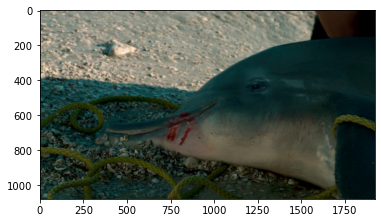

In [14]:
plt.imshow(aaa)

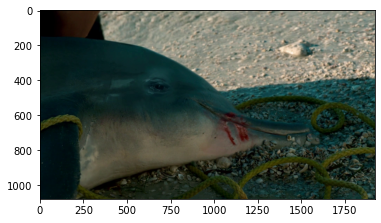

In [15]:
flipped_img = np.fliplr(aaa)
plt.imshow(flipped_img)

In [16]:
class MyDataset(Dataset):
    def __init__(self, path, target_size=(64, 64), num_data_chunks=6, shuffle=False):
        super().__init__(path, target_size, num_data_chunks, shuffle)
        """Initializes the dataset for data chunk collection
        """
        self.target_height, self.target_width = target_size
        self.num_data_chunks = num_data_chunks
        self.shuffle = shuffle
        root_dir = Path(path)
        
        # Directories containing sequences
        directories = sorted(filter(lambda f: f.is_dir(), root_dir.iterdir()))
        
        self.total_num_patches = 0

        for frames_dir in directories:
            # Order frames names alphabetically
            frames_paths = sorted(frames_dir.iterdir())
            # Empty directory
            if not frames_paths:
                continue
            width, height = Image.open(frames_paths[0]).size
            
            # If necessary, you can use more than two frames
            for frames_paths_pair in zip(frames_paths[::2], frames_paths[1::2]):
                # Count patches for the pair
                self.total_num_patches += (width // self.target_width) * (height // self.target_height)
                self._frames_paths_pairs.append(frames_paths_pair)
        
        # Calculate the maximum length of a chunk
        self.chunk_len = (len(self._frames_paths_pairs) - 1) // self.num_data_chunks + 1

    
    def _create_records(self, frames_seq):
        # frames_seq : sequential frames, read from paths of self._frames_paths_pairs
        # If necessary, you can use more than two frames by changing self._frames_paths_pairs
        height, width = frames_seq[0].shape[: 2]
        patch_shape = (self.target_height, self.target_width, 3)

        # Crop the rest of the frames
        height -= height % self.target_height
        width -= width % self.target_width

        # Cut the frames into patches
        first_frame_patches, second_frame_patches = (
            skimage.util.view_as_blocks(
                frame[: height, : width],
                patch_shape
            ).reshape((-1, *patch_shape))
            for frame in frames_seq
        )

        # Separate odd and even rows of the patches
        first_frame_patches_odd_rows = first_frame_patches[:, ::2]
        first_frame_patches_even_rows = first_frame_patches[:, 1::2]
        second_frame_patches_odd_rows = second_frame_patches[:, ::2]
        second_frame_patches_even_rows = second_frame_patches[:, 1::2]

        # Combine an input of I^{odd}_{t} and I^{even}_{t+1} for every patch
        input_patches = np.zeros_like(first_frame_patches)
        input_patches[:, ::2] = first_frame_patches_odd_rows
        input_patches[:, 1::2] = second_frame_patches_even_rows

        # The first ground truth output is I^{even}_{t}
        output_cur_patches = first_frame_patches_even_rows
        # The second ground truth output is I^{odd}_{t+1}
        output_next_patches = second_frame_patches_odd_rows
        
        records = zip(input_patches, zip(output_cur_patches, output_next_patches))
        return records

    
    def __getitem__(self, idx):
        """Returns the input and the outputs for a NN
        of a patch with an index idx
        
        Returns
        -------
            record : (np.array, (np.array, np.array))
        """
        if idx >= len(self):
            raise IndexError

        while True:
            # Some strange code with multiprocessing
            with self._lock:
                if not self._chunk_collecting.is_set():
                    record_idx = idx - self._records_offset.value
                    if record_idx < len(self._records_chunk):
                        self._num_records_returned.value += 1
                        if self._num_records_returned.value == len(self._records_chunk):
                            self._chunk_returned.set()

                        # (merged_patch, (gt_first, gt_second))
                        # Here you can apply some augmentations
                        output = self._records_chunk[record_idx]
                        return output
            assert(self._chunk_idx.value < self.num_data_chunks)
            self._chunk_returned.wait()
            self._collect_new_chunk()

# do augumentations!

In [17]:
import torchvision.transforms as transf

In [18]:
 transf.ColorJitter(brightness=0.1, contrast=0.2, saturation=0, hue=0),

(ColorJitter(brightness=[0.9, 1.1], contrast=[0.8, 1.2], saturation=None, hue=None),)

In [19]:
my_transforms = transf.Compose([
                                transf.ToPILImage(),
                                transf.RandomHorizontalFlip(p=0.5),
                                transf.RandomVerticalFlip(p=0.5),
                                transf.ColorJitter(brightness=0.1, contrast=0.2, saturation=0, hue=0)
                              ])

In [35]:
from multiprocessing import cpu_count

# If you don't have enough memory, increase the number of chunks otherwise decrease
NUM_TRAIN_DATA_CHUNKS = 22
NUM_VLD_DATA_CHUNKS = 5

dataset_trn = MyDataset('data/data/trn', num_data_chunks=NUM_TRAIN_DATA_CHUNKS, shuffle=True)
dataset_vld = MyDataset('data/data/vld', num_data_chunks=NUM_VLD_DATA_CHUNKS)

BATCH_SIZE = 32

# There are some troubles with multiprocessing in jupyter in windows
num_workers = cpu_count() if 'win' not in sys.platform else 0

dataloader_trn = torch.utils.data.DataLoader(dataset_trn,
                                             batch_size=BATCH_SIZE,
                                             num_workers=num_workers)
dataloader_vld = torch.utils.data.DataLoader(dataset_vld,
                                             batch_size=BATCH_SIZE,
                                             num_workers=num_workers)

In [17]:
plt.imshow(dataset_trn[0][0])

KeyboardInterrupt: 

In [ ]:
dataset_trn[0][0][0].dtype

In [ ]:
plt.imshow(dataset_trn[0][1][0])

In [ ]:
batch = next(iter(dataloader_trn))

In [ ]:
conv0 = nn.Conv2d(3, 64, kernel_size=(3, 3), padding=1)
pool0 = nn.MaxPool2d(2, stride = 2)
up0 = nn.UpsamplingBilinear2d(scale_factor=2)
z = batch[0]
x = z.permute(0, 3, 1, 2)
x = conv0(x)
x = pool0(x)
x = up0(x)
x.shape

In [ ]:
plt.imshow(batch[0][0])

In [ ]:
batch[0].shape

### 3. Создадим класс нашей модели

Документация PyTorch: https://pytorch.org/docs/stable/index.html

Следующая ячейка должна содержать архитектуру вашей модели.

 - Комментарий `# GRADED CELL: ...` должен быть первым комментарием в клетке. Его нельзя изменять.
 - Эта клетка должен быть в единственном экземпляре.
 - Оцениваться будет только код, написанный внутри класса `Model`.

In [21]:
# GRADED CELL: Model

class Model(nn.Module):
    def __init__(self):
        """Initializes model's architecture.
        Assumes an input to be (3, height, width) tensor
        """
        super(Model, self).__init__()
        # A common part of the models predicting missing
        # rows of the current and the next frames
        self.conv100 = nn.Conv2d(3, 64, kernel_size=(7, 7), padding=3)
        self.relu100 = nn.ReLU()
        
#         self.conv1 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1)
#         self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 32, kernel_size=(3, 3), padding=1)
        # I^{even}_{t}
        self.conv4_1 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        
        #my blocks
        self.my_relu_x = nn.ReLU()
#         self.my_pool0 = nn.MaxPool2d(2, stride = 2)
#         self.my_up0 = nn.UpsamplingBilinear2d(scale_factor=2)
#         self.my_relu0 = nn.ReLU()
        self.my_conv1 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        self.my_relu7_1 = nn.ReLU()
        self.my_conv7_1 = nn.Conv2d(32, 32, kernel_size=(5, 5), padding=2)
        #my blocks
        
        self.conv4_2 = nn.Conv2d(32, 3, kernel_size=(3, 3), padding=1, stride=(2, 1))
        self.sigmoid4_2 = nn.Sigmoid()
        # I^{odd}_{t+1}
        self.conv5_1 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        
        #my blocks
        self.my_relu_y = nn.ReLU()
#         self.my_pool1 = nn.MaxPool2d(2, stride = 2)
#         self.my_up1 = nn.UpsamplingBilinear2d(scale_factor=2)
#         self.my_relu1 = nn.ReLU()
        self.my_conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        self.my_relu7_2 = nn.ReLU()
        self.my_conv7_2 = nn.Conv2d(32, 32, kernel_size=(5, 5), padding=2)
        #my blocks
        
        
        self.conv5_2 = nn.Conv2d(32, 3, kernel_size=(3, 3), padding=1, stride=(2, 1))
        self.sigmoid5_2 = nn.Sigmoid()
    
    def forward(self, x):
        """Mapping from input to outputs
        
        Parameters
        ----------
            x : torch.tensor
                x is (batch_size, height, width, 3) matrix — model's input
                combined of I^{odd}_{t} and I^{even}_{t+1}
        
        Returns
        -------
            cur_even : torch.tensor
                first model output — I^{even}_t prediction
            next_odd : torch.tensor
                second model output — I^{odd}_{t+1} prediction
        """
        # Make the channel dimension in images go first
        # so that PyTorch processes it correctly
        x = x.permute(0, 3, 1, 2)
        x = self.conv100(x)
        x = self.relu100(x)
#         x = self.conv1(x)
#         x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        
        # A branch that predicts I^{even}_{t}
        cur_even = self.conv4_1(x)
        
        #my blocks
        cur_even = self.my_relu_x(cur_even)
#         cur_even = self.my_pool0(cur_even)
#         cur_even = self.my_up0(cur_even)
#         cur_even = self.my_relu0(cur_even)
        cur_even = self.my_conv1(cur_even)
        cur_even = self.my_relu7_1(cur_even)
        cur_even = self.my_conv7_1(cur_even)
        #my blocks
        
        cur_even = self.conv4_2(cur_even)
        cur_even = self.sigmoid4_2(cur_even)
        # Put the channel dimension back
        cur_even = cur_even.permute(0, 2, 3, 1)
        
        # A branch that predicts I^{odd}_{t+1}
        next_odd = self.conv5_1(x)
        
        #my blocks
        next_odd = self.my_relu_y(next_odd)
#         next_odd = self.my_pool1(next_odd)
#         next_odd = self.my_up1(next_odd)
#         next_odd = self.my_relu1(next_odd)
        next_odd = self.my_conv1(next_odd)
        next_odd = self.my_relu7_2(next_odd)
        next_odd = self.my_conv7_2(next_odd)
        #my blocks
        
        
        next_odd = self.conv5_2(next_odd)
        next_odd = self.sigmoid5_2(next_odd)
        # Put the channel dimension back
        next_odd = next_odd.permute(0, 2, 3, 1)
        
        return cur_even, next_odd

In [22]:
# # GRADED CELL: Model

# class Model(nn.Module):
#     def __init__(self):
#         """Initializes model's architecture.
#         Assumes an input to be (3, height, width) tensor
#         """
#         super(Model, self).__init__()
#         # A common part of the models predicting missing
#         # rows of the current and the next frames
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), padding=1)
#         self.relu1 = nn.ReLU()
#         self.conv2 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1)
#         self.relu2 = nn.ReLU()
#         self.conv3 = nn.Conv2d(64, 32, kernel_size=(3, 3), padding=1)
#         # I^{even}_{t}
#         self.conv4_1 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
#         self.conv4_2 = nn.Conv2d(32, 3, kernel_size=(3, 3), padding=1, stride=(2, 1))
#         self.sigmoid4_2 = nn.Sigmoid()
#         # I^{odd}_{t+1}
#         self.conv5_1 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
#         self.conv5_2 = nn.Conv2d(32, 3, kernel_size=(3, 3), padding=1, stride=(2, 1))
#         self.sigmoid5_2 = nn.Sigmoid()
    
#     def forward(self, x):
#         """Mapping from input to outputs
        
#         Parameters
#         ----------
#             x : torch.tensor
#                 x is (batch_size, height, width, 3) matrix — model's input
#                 combined of I^{odd}_{t} and I^{even}_{t+1}
        
#         Returns
#         -------
#             cur_even : torch.tensor
#                 first model output — I^{even}_t prediction
#             next_odd : torch.tensor
#                 second model output — I^{odd}_{t+1} prediction
#         """
#         # Make the channel dimension in images go first
#         # so that PyTorch processes it correctly
#         x = x.permute(0, 3, 1, 2)
#         x = self.conv1(x)
#         x = self.relu1(x)
#         x = self.conv2(x)
#         x = self.relu2(x)
#         x = self.conv3(x)
        
#         # A branch that predicts I^{even}_{t}
#         cur_even = self.conv4_1(x)
#         cur_even = self.conv4_2(cur_even)
#         cur_even = self.sigmoid4_2(cur_even)
#         # Put the channel dimension back
#         cur_even = cur_even.permute(0, 2, 3, 1)
        
#         # A branch that predicts I^{odd}_{t+1}
#         next_odd = self.conv5_1(x)
#         next_odd = self.conv5_2(next_odd)
#         next_odd = self.sigmoid5_2(next_odd)
#         # Put the channel dimension back
#         next_odd = next_odd.permute(0, 2, 3, 1)
        
#         return cur_even, next_odd

### 4. Обучим заданную модель

__Пайплайн обучения__:
* Определить __таргет__. В нашей задаче это недостающие строки двух последовательных кадров
* Определить __функцию потерь (loss)__. У нас всё просто: хочется, чтобы изображения мало отличались друг от друга, поэтому используем MSE между таргетом и предсказанием сети.
* Выбрать __оптимизатор__. Задача не из простых, но если хочется, чтобы всё быстро полетело, то лучше всего `Adam`.

Шпаргалка по отпимизаторам: https://habr.com/ru/post/318970/

In [30]:
# Use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize a model
# model = Model()
model = torch.load('../input/data-deint/model7.pth').to(device).eval()
# Move its parameters to the GPU
model.to(device)

print(model)
print("Number of parameters:", sum([p.numel() for p in model.parameters()]))

Model(
  (conv100): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (relu100): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (my_relu_x): ReLU()
  (my_conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (my_relu7_1): ReLU()
  (my_conv7_1): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4_2): Conv2d(32, 3, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
  (sigmoid4_2): Sigmoid()
  (conv5_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (my_relu_y): ReLU()
  (my_conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (my_relu7_2): ReLU()
  (my_conv7_2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5_2): Conv2d(32, 3, kernel_size=(3, 3), 

In [31]:
# Define a loss function
criterion = nn.MSELoss().to(device)
# Pick Adam algorithm as an optimizer
optimizer = torch.optim.Adam(model.parameters())
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)

In [32]:
# torch.optim.lr_scheduler import LambdaLR
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# # Assuming optimizer has two groups.
# lambda_group1 = lambda epoch: epoch // 30
# lambda_group2 = lambda epoch: 0.95 ** epoch
# scheduler = LambdaLR(optimizer, lr_lambda=[lambda1, lambda2])

In [36]:
def train_model(model, epochs):
    """Trains the given model with the given number of epochs
    and returns the history of training
    
    Parameters
    ----------
        model : Model
        epochs : int
            number of epochs to train the model
        device : torch.device
    
    Returns
    -------
        history : dict {"loss"     : [ (epoch_num, train_loss) ],
                        "val_loss" : [ (epoch_num, val_loss) ]}
    """
    history = {
        "loss": [],
        "val_loss": [],
    }
    for epoch in range(1, epochs+1):
        print(f"Epoch {epoch}/{epochs}:", flush=True)
        batch_bar = tqdm(total=len(dataloader_trn))
        # Recalculate train loss on every sample using a moving average
        moving_avg_loss = 0.0
        train_losses = []
        # Reset iterators
        dataloader_trn.dataset.reset()
        dataloader_vld.dataset.reset()
        
        ##################
        ### TRAIN LOOP ###
        ##################
        for i, data in enumerate(dataloader_trn):
            inputs, gt_outputs = data
            # Move data to GPU
            inputs = inputs.to(device)
            gt_outputs = list(map(lambda x: x.to(device), gt_outputs))
            
            # Forward pass
            outputs = model(inputs)
            # Calculate loss, make a backward pass and update the parameters of the model
            loss = criterion(outputs[0], gt_outputs[0]) + criterion(outputs[1], gt_outputs[1])
            # Set to zero the parameter gradients for the current batch
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate moving average loss
            moving_avg_loss = loss.item() if i == 0 else (0.99 * moving_avg_loss + 0.01 * loss.item())
            
            # Save train batch loss
            train_losses.append(loss.item())
            batch_bar.set_postfix_str(f"\tloss = {moving_avg_loss :.8f}")
            batch_bar.update(1)
            
        history["loss"].append((epoch, np.mean(train_losses)))
        print(f"Train loss: {np.mean(train_losses)}\n", flush=True)
        
        #######################
        ### VALIDATION LOOP ###
        #######################
        # Freeze model params for validation
        model.eval()
        batch_bar = tqdm(total=len(dataloader_vld))
        val_losses = []
        for i, data in enumerate(dataloader_vld):
            inputs, gt_outputs = data
            inputs = inputs.to(device)
            gt_outputs = list(map(lambda x: x.to(device), gt_outputs))
            outputs = model(inputs)
            loss = criterion(outputs[0], gt_outputs[0]) + criterion(outputs[1], gt_outputs[1])
            val_losses.append(loss.item())
            batch_bar.set_postfix_str(f"\tval loss = {loss.item() :.8f}")
            batch_bar.update(1)
        # Calculate mean loss over samples
        mean_vld_loss = np.mean(val_losses)
        history["val_loss"].append((epoch, mean_vld_loss))
        print(f"Validation loss: {mean_vld_loss}\n", flush=True)
        # Unfreeze model params for training
        model.train()
        
    print("Finished training!")
    return history

torch.Size([32, 32, 64, 64])

In [37]:
history = train_model(model=model, epochs=20)

Epoch 1/20:


  0%|          | 0/7200 [00:00<?, ?it/s]

Train loss: 0.0002414870399095687



  0%|          | 0/900 [00:00<?, ?it/s]

Validation loss: 0.0006157295791209094

Epoch 2/20:


  0%|          | 0/7200 [00:00<?, ?it/s]

Train loss: 0.0002496664865399604



  0%|          | 0/900 [00:00<?, ?it/s]

Validation loss: 0.0005970426612587214

Epoch 3/20:


  0%|          | 0/7200 [00:00<?, ?it/s]

Train loss: 0.0002442874499966921



  0%|          | 0/900 [00:00<?, ?it/s]

Validation loss: 0.0006378321323605441

Epoch 4/20:


  0%|          | 0/7200 [00:00<?, ?it/s]

Train loss: 0.00023650350696193022



  0%|          | 0/900 [00:00<?, ?it/s]

Validation loss: 0.0005984058790662693

Epoch 5/20:


  0%|          | 0/7200 [00:00<?, ?it/s]

Train loss: 0.0002477870581459582



  0%|          | 0/900 [00:00<?, ?it/s]

Validation loss: 0.0006093745383674332

Epoch 6/20:


  0%|          | 0/7200 [00:00<?, ?it/s]

Train loss: 0.00023456545770386583



  0%|          | 0/900 [00:00<?, ?it/s]

Validation loss: 0.0005961214766017283

Epoch 7/20:


  0%|          | 0/7200 [00:00<?, ?it/s]

Train loss: 0.00023786296921672248



  0%|          | 0/900 [00:00<?, ?it/s]

Validation loss: 0.0006020428832676138

Epoch 8/20:


  0%|          | 0/7200 [00:00<?, ?it/s]

KeyboardInterrupt: 

NameError: name 'history' is not defined

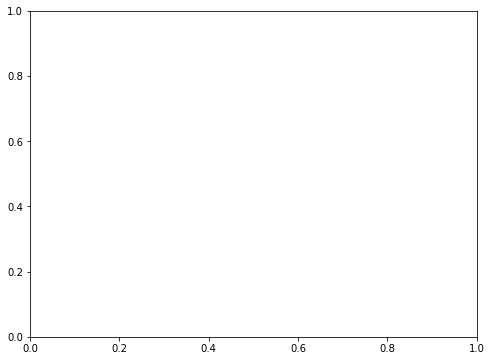

In [88]:
_, ax = plt.subplots(figsize=(8, 6))

ax.plot(*zip(*history["loss"]), label='Train', c="lightblue", zorder=0)
ax.plot(*zip(*history["val_loss"]), label='Val', c="darkgreen", linestyle='-', marker="o", zorder=1)

ax.set_xlabel('Epoch #')
ax.set_ylabel('MSE')
ax.set_title('Training')

ax.legend()
ax.grid()

#ax.set_yscale("log")
#ax.set_ylim([5e-5, 0.05])

plt.show()

### 5. Посмотрим на выход модели

In [38]:
def evaluate(model, interlaced_image):
    with torch.no_grad():
        # Add batch dimension and wrap it into a tensor on the GPU
        model_input = torch.tensor(interlaced_image[np.newaxis, ...], device=device)
        # Predict 
        current_even, next_odd = model(model_input)

        current_even = current_even.cpu().numpy()[0]
        next_odd = next_odd.cpu().numpy()[0]

        first = np.zeros_like(interlaced_image)
        first[::2] = interlaced_image[::2]
        first[1::2] = current_even

        second = np.zeros_like(interlaced_image)
        second[1::2] = interlaced_image[1::2]
        second[::2] = next_odd

        return first, second

In [39]:
test_image = np.array(Image.open('data/data/test/interlace/0/00000.png'), dtype=np.float32) / 255.
gt_image = np.array(Image.open('data/data/test/gt/0/00000.png'), dtype=np.float32) / 255.

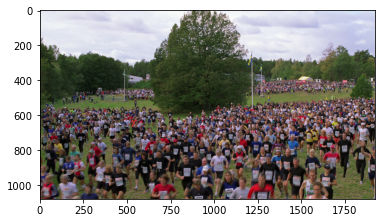

In [40]:
plt.imshow(test_image)

In [41]:
first, second = evaluate(model, test_image)

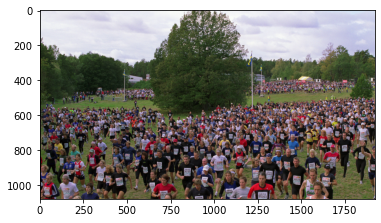

In [42]:
plt.imshow(first)

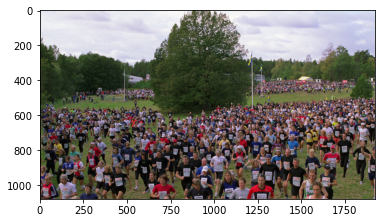

In [43]:
plt.imshow(second)

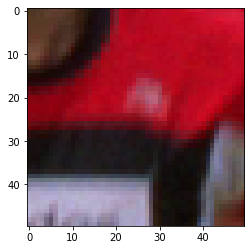

In [44]:
plt.imshow(gt_image[1000:1050, 1275:1325])

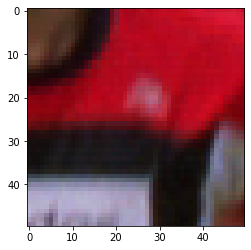

In [45]:
plt.imshow(first[1000:1050, 1275:1325])

In [47]:
# Сохраним полученную модель
torch.save(model, 'model8.pth')

### 6. Протестируем полученную модель

Следующая ячейка должна вызывать вашу модель и получать из последовательности interlaced кадров deinterlaced кадры. Так же укажите относительный путь до сохранения в параметре model_path этой функции.

 - Комментарий `# GRADED CELL: ...` должен быть первым комментарием в клетке. Его нельзя изменять.
 - Эта клетка должен быть в единственном экземпляре.
 - Оцениваться будет только код, написанный внутри функции `test_model`.

In [48]:
# GRADED CELL: test_model

def test_model(input_frames_dir, model_path='model.pth'):
    """Calculates deinterlaced frames from interlaced

    Parameters
    ----------
        model: sting 
          path to pytorch model
        input_frames_dir : string
          path to interlaced framed

    Returns
    -------
        output_frames: list of deinterlaces frames
    """
    
    #model = torch.load('model.pth').to(device).eval()
    model = torch.load(model_path).to(device).eval()
    output_frames = []
    
    # If your model uses other inputs write an implementation of this function
    my_evaluate = evaluate

    for input_name in sorted(os.listdir(input_frames_dir)):
        if '.DS_Store' in input_name:
            continue
        input_path = os.path.join(input_frames_dir, input_name)
        interlaced_frame = np.array(Image.open(input_path), dtype=np.float32) / 255.

        output_frames.extend(my_evaluate(model, interlaced_frame))
    return output_frames

In [49]:
model_outputs = test_model('./data/data/test/interlace/0')

In [50]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def calculate_metrics(model_outputs, gt_path):
    """Calculates average PSNR and SSIM on the passed data

    Parameters
    ----------
        model_outputs
            list of deinterlaced frames
        gt_path : string
            path to gt frames

    Returns
    -------
        (PSNR, SSIM)
    """
    gt_frames = [np.array(Image.open(os.path.join(gt_path, x)), dtype=np.float32) / 255. 
                 for x in sorted(os.listdir(gt_path)) if '.DS_Store' not in x]
    assert len(gt_frames) == len(model_outputs)
    ssim_list = []
    psnr_list = []
    for gt_frame, deinterlaced_frame in tqdm(zip(gt_frames, model_outputs)):
        ssim_list.append(ssim(gt_frame, deinterlaced_frame, multichannel=True))
        psnr_list.append(psnr(gt_frame, deinterlaced_frame))
    return np.mean(ssim_list), np.mean(psnr_list)

In [51]:
calculate_metrics(model_outputs, './data/data/test/gt/0')

0it [00:00, ?it/s]

(0.9784673401353673, 34.69208502136256)

# best with model 8 (0.9784673401353673, 34.69208502136256)
дообучить до среды

# NEW BEST2 (0.9747085587028701, 34.235984408058364) model7

# NEW BEST (0.9689639448070679, 33.02055315349208)
model6.pth
class Model(nn.Module):
    def __init__(self):
        """Initializes model's architecture.
        Assumes an input to be (3, height, width) tensor
        """
        super(Model, self).__init__()
        # A common part of the models predicting missing
        # rows of the current and the next frames
        self.conv100 = nn.Conv2d(3, 64, kernel_size=(7, 7), padding=3)
        self.relu100 = nn.ReLU()
        
#         self.conv1 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1)
#         self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 32, kernel_size=(3, 3), padding=1)
        # I^{even}_{t}
        self.conv4_1 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        
        #my blocks
        self.my_relu_x = nn.ReLU()
#         self.my_pool0 = nn.MaxPool2d(2, stride = 2)
#         self.my_up0 = nn.UpsamplingBilinear2d(scale_factor=2)
#         self.my_relu0 = nn.ReLU()
        self.my_conv1 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        self.my_relu7_1 = nn.ReLU()
        self.my_conv7_1 = nn.Conv2d(32, 32, kernel_size=(5, 5), padding=2)
        #my blocks
        
        self.conv4_2 = nn.Conv2d(32, 3, kernel_size=(3, 3), padding=1, stride=(2, 1))
        self.sigmoid4_2 = nn.Sigmoid()
        # I^{odd}_{t+1}
        self.conv5_1 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        
        #my blocks
        self.my_relu_y = nn.ReLU()
#         self.my_pool1 = nn.MaxPool2d(2, stride = 2)
#         self.my_up1 = nn.UpsamplingBilinear2d(scale_factor=2)
#         self.my_relu1 = nn.ReLU()
        self.my_conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        self.my_relu7_2 = nn.ReLU()
        self.my_conv7_2 = nn.Conv2d(32, 32, kernel_size=(5, 5), padding=2)
        #my blocks
        
        
        self.conv5_2 = nn.Conv2d(32, 3, kernel_size=(3, 3), padding=1, stride=(2, 1))
        self.sigmoid5_2 = nn.Sigmoid()
    
    def forward(self, x):
        """Mapping from input to outputs
        
        Parameters
        ----------
            x : torch.tensor
                x is (batch_size, height, width, 3) matrix — model's input
                combined of I^{odd}_{t} and I^{even}_{t+1}
        
        Returns
        -------
            cur_even : torch.tensor
                first model output — I^{even}_t prediction
            next_odd : torch.tensor
                second model output — I^{odd}_{t+1} prediction
        """
        # Make the channel dimension in images go first
        # so that PyTorch processes it correctly
        x = x.permute(0, 3, 1, 2)
        x = self.conv100(x)
        x = self.relu100(x)
#         x = self.conv1(x)
#         x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        
        # A branch that predicts I^{even}_{t}
        cur_even = self.conv4_1(x)
        
        #my blocks
        cur_even = self.my_relu_x(cur_even)
#         cur_even = self.my_pool0(cur_even)
#         cur_even = self.my_up0(cur_even)
#         cur_even = self.my_relu0(cur_even)
        cur_even = self.my_conv1(cur_even)
        cur_even = self.my_relu7_1(cur_even)
        cur_even = self.my_conv7_1(cur_even)
        #my blocks
        
        cur_even = self.conv4_2(cur_even)
        cur_even = self.sigmoid4_2(cur_even)
        # Put the channel dimension back
        cur_even = cur_even.permute(0, 2, 3, 1)
        
        # A branch that predicts I^{odd}_{t+1}
        next_odd = self.conv5_1(x)
        
        #my blocks
        next_odd = self.my_relu_y(next_odd)
#         next_odd = self.my_pool1(next_odd)
#         next_odd = self.my_up1(next_odd)
#         next_odd = self.my_relu1(next_odd)
        next_odd = self.my_conv1(next_odd)
        next_odd = self.my_relu7_2(next_odd)
        next_odd = self.my_conv7_2(next_odd)
        #my blocks
        
        
        next_odd = self.conv5_2(next_odd)
        next_odd = self.sigmoid5_2(next_odd)
        # Put the channel dimension back
        next_odd = next_odd.permute(0, 2, 3, 1)
        
        return cur_even, next_odd

new model: (0.9602841712239335, 31.54965407495414)

new model2 :(0.9613950301091555, 31.63500566140159)

# cur best big_data = (0.9647826181940085, 32.00326538718433)

class Model(nn.Module):
    def __init__(self):
        """Initializes model's architecture.
        Assumes an input to be (3, height, width) tensor
        """
        super(Model, self).__init__()
        # A common part of the models predicting missing
        # rows of the current and the next frames
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 32, kernel_size=(3, 3), padding=1)
        # I^{even}_{t}
        self.conv4_1 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        
        #my blocks
        self.my_relu_x = nn.ReLU()
        self.my_pool0 = nn.MaxPool2d(2, stride = 2)
        self.my_up0 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.my_relu0 = nn.ReLU()
        self.my_conv1 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        self.my_relu7_1 = nn.ReLU()
        self.my_conv7_1 = nn.Conv2d(32, 32, kernel_size=(5, 5), padding=2)
        #my blocks
        
        self.conv4_2 = nn.Conv2d(32, 3, kernel_size=(3, 3), padding=1, stride=(2, 1))
        self.sigmoid4_2 = nn.Sigmoid()
        # I^{odd}_{t+1}
        self.conv5_1 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        
        #my blocks
        self.my_relu_y = nn.ReLU()
        self.my_pool1 = nn.MaxPool2d(2, stride = 2)
        self.my_up1 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.my_relu1 = nn.ReLU()
        self.my_conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        self.my_relu7_2 = nn.ReLU()
        self.my_conv7_2 = nn.Conv2d(32, 32, kernel_size=(5, 5), padding=2)
        #my blocks
        
        
        self.conv5_2 = nn.Conv2d(32, 3, kernel_size=(3, 3), padding=1, stride=(2, 1))
        self.sigmoid5_2 = nn.Sigmoid()
    
    def forward(self, x):
        """Mapping from input to outputs
        
        Parameters
        ----------
            x : torch.tensor
                x is (batch_size, height, width, 3) matrix — model's input
                combined of I^{odd}_{t} and I^{even}_{t+1}
        
        Returns
        -------
            cur_even : torch.tensor
                first model output — I^{even}_t prediction
            next_odd : torch.tensor
                second model output — I^{odd}_{t+1} prediction
        """
        # Make the channel dimension in images go first
        # so that PyTorch processes it correctly
        x = x.permute(0, 3, 1, 2)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        
        # A branch that predicts I^{even}_{t}
        cur_even = self.conv4_1(x)
        
        #my blocks
        cur_even = self.my_relu_x(cur_even)
        cur_even = self.my_pool0(cur_even)
        cur_even = self.my_up0(cur_even)
        cur_even = self.my_relu0(cur_even)
        cur_even = self.my_conv1(cur_even)
        cur_even = self.my_relu7_1(cur_even)
        cur_even = self.my_conv7_1(cur_even)
        #my blocks
        
        cur_even = self.conv4_2(cur_even)
        cur_even = self.sigmoid4_2(cur_even)
        # Put the channel dimension back
        cur_even = cur_even.permute(0, 2, 3, 1)
        
        # A branch that predicts I^{odd}_{t+1}
        next_odd = self.conv5_1(x)
        
        #my blocks
        next_odd = self.my_relu_y(next_odd)
        next_odd = self.my_pool1(next_odd)
        next_odd = self.my_up1(next_odd)
        next_odd = self.my_relu1(next_odd)
        next_odd = self.my_conv1(next_odd)
        next_odd = self.my_relu7_2(next_odd)
        next_odd = self.my_conv7_2(next_odd)
        #my blocks
        
        
        next_odd = self.conv5_2(next_odd)
        next_odd = self.sigmoid5_2(next_odd)
        # Put the channel dimension back
        next_odd = next_odd.permute(0, 2, 3, 1)
        
        return cur_even, next_odd

(0.8845890617115785, 27.393954127405202)

(0.9640007614769178, 32.39622538620844)

(0.9623555940985897, 31.65266220896985)

In [ ]:
(0.9642014094471503, 32.01983300924648)
class Model(nn.Module):
    def __init__(self):
        """Initializes model's architecture.
        Assumes an input to be (3, height, width) tensor
        """
        super(Model, self).__init__()
        # A common part of the models predicting missing
        # rows of the current and the next frames
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 32, kernel_size=(3, 3), padding=1)
        # I^{even}_{t}
        self.conv4_1 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        
        #my blocks
        self.my_relu_x = nn.ReLU()
        self.my_pool0 = nn.MaxPool2d(2, stride = 2)
        self.my_up0 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.my_relu0 = nn.ReLU()
        self.my_conv1 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        self.my_relu7_1 = nn.ReLU()
        self.my_conv7_1 = nn.Conv2d(32, 32, kernel_size=(5, 5), padding=2)
        #my blocks
        
        self.conv4_2 = nn.Conv2d(32, 3, kernel_size=(3, 3), padding=1, stride=(2, 1))
        self.sigmoid4_2 = nn.Sigmoid()
        # I^{odd}_{t+1}
        self.conv5_1 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        
        #my blocks
        self.my_relu_y = nn.ReLU()
        self.my_pool1 = nn.MaxPool2d(2, stride = 2)
        self.my_up1 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.my_relu1 = nn.ReLU()
        self.my_conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        self.my_relu7_2 = nn.ReLU()
        self.my_conv7_2 = nn.Conv2d(32, 32, kernel_size=(5, 5), padding=2)
        #my blocks
        
        
        self.conv5_2 = nn.Conv2d(32, 3, kernel_size=(3, 3), padding=1, stride=(2, 1))
        self.sigmoid5_2 = nn.Sigmoid()
    
    def forward(self, x):
        """Mapping from input to outputs
        
        Parameters
        ----------
            x : torch.tensor
                x is (batch_size, height, width, 3) matrix — model's input
                combined of I^{odd}_{t} and I^{even}_{t+1}
        
        Returns
        -------
            cur_even : torch.tensor
                first model output — I^{even}_t prediction
            next_odd : torch.tensor
                second model output — I^{odd}_{t+1} prediction
        """
        # Make the channel dimension in images go first
        # so that PyTorch processes it correctly
        x = x.permute(0, 3, 1, 2)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        
        # A branch that predicts I^{even}_{t}
        cur_even = self.conv4_1(x)
        
        #my blocks
        cur_even = self.my_relu_x(cur_even)
        cur_even = self.my_pool0(cur_even)
        cur_even = self.my_up0(cur_even)
        cur_even = self.my_relu0(cur_even)
        cur_even = self.my_conv1(cur_even)
        cur_even = self.my_relu7_1(cur_even)
        cur_even = self.my_conv7_1(cur_even)
        #my blocks
        
        cur_even = self.conv4_2(cur_even)
        cur_even = self.sigmoid4_2(cur_even)
        # Put the channel dimension back
        cur_even = cur_even.permute(0, 2, 3, 1)
        
        # A branch that predicts I^{odd}_{t+1}
        next_odd = self.conv5_1(x)
        
        #my blocks
        next_odd = self.my_relu_y(next_odd)
        next_odd = self.my_pool1(next_odd)
        next_odd = self.my_up1(next_odd)
        next_odd = self.my_relu1(next_odd)
        next_odd = self.my_conv1(next_odd)
        next_odd = self.my_relu7_2(next_odd)
        next_odd = self.my_conv7_2(next_odd)
        #my blocks
        
        
        next_odd = self.conv5_2(next_odd)
        next_odd = self.sigmoid5_2(next_odd)
        # Put the channel dimension back
        next_odd = next_odd.permute(0, 2, 3, 1)
        
        return cur_even, next_odd